## 1. 라이브러리 및 데이터 로드

In [1]:
# import
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import warnings
warnings.filterwarnings('ignore')

In [2]:
# API에서 실험 결과 로드
API_BASE = "http://127.0.0.1:8000"

response = requests.get(f"{API_BASE}/api/analytics/experiments/exp_dashboard_search_v1/results")
data = response.json()

print("✅ 데이터 로드 완료")
print(f"실험명: {data['experiment']['name']}")
print(f"기간: {data['experiment']['start_date']} ~ {data['experiment']['end_date']}")

✅ 데이터 로드 완료
실험명: 대시보드 검색창 노출 테스트
기간: 2025-12-06 ~ 2025-12-20


## 실험 데이터 요약

In [3]:
# 그룹별 데이터 추출
control = data['primary_metric']['control']
treatment = data['primary_metric']['treatment']

# 요약 테이블 생성
summary_df = pd.DataFrame({
    '지표': ['세션 수', '검색 세션 수', '검색 사용률 (%)'],
    'Control': [control['total_sessions'], control['sessions_with_search'], control['search_usage_rate']],
    'Treatment': [treatment['total_sessions'], treatment['sessions_with_search'], treatment['search_usage_rate']]
})

print("\n📊 실험 데이터 요약")
print("=" * 50)
print(summary_df.to_string(index=False))
print("=" * 50)

# Lift 계산
lift = (treatment['search_usage_rate'] - control['search_usage_rate']) / control['search_usage_rate'] * 100
print(f"\n📈 Lift: +{lift:.1f}%")


📊 실험 데이터 요약
        지표  Control  Treatment
      세션 수   520.00     525.00
   검색 세션 수    90.00     194.00
검색 사용률 (%)    17.31      36.95

📈 Lift: +113.5%


## 3. Two-Proportion Z-Test (양측 검정)

두 그룹의 비율 차이가 통계적으로 유의한지 검정한다.

- **귀무가설 (H₀)**: p_treatment = p_control (두 그룹의 검색 사용률은 같다)
- **대립가설 (H₁)**: p_treatment ≠ p_control (두 그룹의 검색 사용률은 다르다)

In [4]:
def two_proportion_z_test(n1, x1, n2, x2, alternative='two-sided'):
    """
    Two-Proportion Z-Test
    
    Parameters:
    -----------
    n1, n2: 각 그룹의 샘플 크기
    x1, x2: 각 그룹의 성공(전환) 수
    alternative: 'two-sided', 'larger', 'smaller'
    
    Returns:
    --------
    z_score, p_value, pooled_se
    """
    # 각 그룹의 비율
    p1 = x1 / n1
    p2 = x2 / n2
    
    # Pooled proportion (합동 비율)
    p_pooled = (x1 + x2) / (n1 + n2)
    
    # Standard Error (표준오차)
    se = np.sqrt(p_pooled * (1 - p_pooled) * (1/n1 + 1/n2))
    
    # Z-score
    z = (p2 - p1) / se
    
    # P-value
    if alternative == 'two-sided':
        p_value = 2 * (1 - norm.cdf(abs(z)))
    elif alternative == 'larger':
        p_value = 1 - norm.cdf(z)
    else:  # smaller
        p_value = norm.cdf(z)
    
    return z, p_value, se, p_pooled

# 검정 실행
n_control = control['total_sessions']
x_control = control['sessions_with_search']
n_treatment = treatment['total_sessions']
x_treatment = treatment['sessions_with_search']

z_score, p_value, se, p_pooled = two_proportion_z_test(
    n_control, x_control, n_treatment, x_treatment
)

print("\n🔬 Two-Proportion Z-Test 결과")
print("=" * 50)
print(f"Control 비율 (p₁):     {x_control/n_control:.4f} ({x_control}/{n_control})")
print(f"Treatment 비율 (p₂):   {x_treatment/n_treatment:.4f} ({x_treatment}/{n_treatment})")
print(f"Pooled 비율:           {p_pooled:.4f}")
print(f"표준오차 (SE):         {se:.4f}")
print(f"Z-score:               {z_score:.4f}")
print(f"P-value:               {p_value:.6f}")
print("=" * 50)


🔬 Two-Proportion Z-Test 결과
Control 비율 (p₁):     0.1731 (90/520)
Treatment 비율 (p₂):   0.3695 (194/525)
Pooled 비율:           0.2718
표준오차 (SE):         0.0275
Z-score:               7.1373
P-value:               0.000000


In [5]:
# 유의성 판정
alpha = 0.05
if p_value < alpha:
    print(f"\n✅ 결론: p-value ({p_value:.6f}) < α ({alpha})")
    print("   귀무가설 기각 → 두 그룹 간 차이가 통계적으로 유의함")
else:
    print(f"\n❌ 결론: p-value ({p_value:.6f}) >= α ({alpha})")
    print("   귀무가설 채택 → 두 그룹 간 차이가 유의하지 않음")


✅ 결론: p-value (0.000000) < α (0.05)
   귀무가설 기각 → 두 그룹 간 차이가 통계적으로 유의함


## 4. 신뢰구간 (Confidence Interval) 계산
두 비율의 차이에 대한 95% 신뢰구간을 계산한다.

In [6]:
def confidence_interval_for_diff(n1, x1, n2, x2, confidence=0.95):
    """
    두 비율 차이의 신뢰구간 계산
    """
    p1 = x1 / n1
    p2 = x2 / n2
    diff = p2 - p1
    
    # 개별 표준오차 (non-pooled)
    se_diff = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    
    # Z critical value
    z_critical = norm.ppf((1 + confidence) / 2)
    
    # 신뢰구간
    ci_lower = diff - z_critical * se_diff
    ci_upper = diff + z_critical * se_diff
    
    return diff, ci_lower, ci_upper, se_diff

diff, ci_lower, ci_upper, se_diff = confidence_interval_for_diff(
    n_control, x_control, n_treatment, x_treatment
)

print("\n📐 95% 신뢰구간")
print("=" * 50)
print(f"비율 차이 (p₂ - p₁):  {diff:.4f} ({diff*100:.2f}%p)")
print(f"표준오차:             {se_diff:.4f}")
print(f"95% CI:               [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"                      [{ci_lower*100:.2f}%p, {ci_upper*100:.2f}%p]")
print("=" * 50)

if ci_lower > 0:
    print("\n✅ 신뢰구간이 0을 포함하지 않음 → Treatment가 확실히 더 효과적")
elif ci_upper < 0:
    print("\n❌ 신뢰구간이 0보다 작음 → Control이 더 효과적")
else:
    print("\n⚠️ 신뢰구간이 0을 포함 → 결론 불확실")


📐 95% 신뢰구간
비율 차이 (p₂ - p₁):  0.1964 (19.64%p)
표준오차:             0.0268
95% CI:               [0.1439, 0.2490]
                      [14.39%p, 24.90%p]

✅ 신뢰구간이 0을 포함하지 않음 → Treatment가 확실히 더 효과적


## 5. 검정력 분석 (Power Analysis)
현재 샘플 크기에서 실제 효과를 탐지할 확률(검정력)을 계산한다.

In [7]:
def calculate_power(n1, n2, p1, p2, alpha=0.05):
    """
    검정력 계산
    
    Parameters:
    -----------
    n1, n2: 각 그룹의 샘플 크기
    p1, p2: 실제 비율
    alpha: 유의수준
    """
    # Effect size (Cohen's h)
    h = 2 * (np.arcsin(np.sqrt(p2)) - np.arcsin(np.sqrt(p1)))
    
    # 표준오차
    se = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    
    # Z critical (양측검정)
    z_alpha = norm.ppf(1 - alpha/2)
    
    # 검정력
    z_beta = (abs(p2 - p1) / se) - z_alpha
    power = norm.cdf(z_beta)
    
    return power, h

p1 = x_control / n_control
p2 = x_treatment / n_treatment

power, cohens_h = calculate_power(n_control, n_treatment, p1, p2)

print("\n⚡ 검정력 분석 (Power Analysis)")
print("=" * 50)
print(f"유의수준 (α):          {alpha}")
print(f"Cohen's h (효과 크기): {cohens_h:.4f}")
print(f"검정력 (1-β):          {power:.4f} ({power*100:.1f}%)")
print("=" * 50)


⚡ 검정력 분석 (Power Analysis)
유의수준 (α):          0.05
Cohen's h (효과 크기): 0.4486
검정력 (1-β):          1.0000 (100.0%)


In [8]:
# 효과 크기 해석
if abs(cohens_h) < 0.2:
    effect_size_text = "Small (작은 효과)"
elif abs(cohens_h) < 0.5:
    effect_size_text = "Medium (중간 효과)"
else:
    effect_size_text = "Large (큰 효과)"

print(f"\n효과 크기 해석: {effect_size_text}")

if power >= 0.8:
    print(f"✅ 검정력 {power*100:.1f}% → 충분한 검정력 (≥80%)")
else:
    print(f"⚠️ 검정력 {power*100:.1f}% → 검정력 부족 (<80%)")


효과 크기 해석: Medium (중간 효과)
✅ 검정력 100.0% → 충분한 검정력 (≥80%)


## 6. 필요 샘플 크기 계산
목표 검정력 80%를 달성하기 위해 필요한 최소 샘플 크기를 계산한다.

In [9]:
def required_sample_size(p1, p2, alpha=0.05, power=0.8):
    """
    필요 샘플 크기 계산 (각 그룹당)
    """
    # Z values
    z_alpha = norm.ppf(1 - alpha/2)
    z_beta = norm.ppf(power)
    
    # Pooled proportion
    p_bar = (p1 + p2) / 2
    
    # 필요 샘플 크기
    n = ((z_alpha * np.sqrt(2 * p_bar * (1 - p_bar)) + 
          z_beta * np.sqrt(p1 * (1 - p1) + p2 * (1 - p2))) ** 2) / ((p2 - p1) ** 2)
    
    return int(np.ceil(n))

# 다양한 시나리오 계산
print("\n📏 필요 샘플 크기 계산")
print("=" * 50)

# 현재 관찰된 효과 기준
n_required = required_sample_size(p1, p2)
print(f"관찰된 효과 ({p1:.2%} → {p2:.2%}) 탐지 시:")
print(f"  → 그룹당 최소 {n_required}개 세션 필요")
print(f"  → 현재: Control {n_control}, Treatment {n_treatment}")

# MDE (Minimum Detectable Effect) 시나리오
print(f"\n다양한 MDE 시나리오 (Control = {p1:.2%} 기준):")
print("-" * 50)

for relative_lift in [0.1, 0.2, 0.3, 0.5]:
    p2_scenario = p1 * (1 + relative_lift)
    n_scenario = required_sample_size(p1, p2_scenario)
    print(f"  +{relative_lift*100:.0f}% lift ({p1:.2%} → {p2_scenario:.2%}): 그룹당 {n_scenario:,}개")


📏 필요 샘플 크기 계산
관찰된 효과 (17.31% → 36.95%) 탐지 시:
  → 그룹당 최소 80개 세션 필요
  → 현재: Control 520, Treatment 525

다양한 MDE 시나리오 (Control = 17.31% 기준):
--------------------------------------------------
  +10% lift (17.31% → 19.04%): 그룹당 7,792개
  +20% lift (17.31% → 20.77%): 그룹당 2,019개
  +30% lift (17.31% → 22.50%): 그룹당 928개
  +50% lift (17.31% → 25.96%): 그룹당 355개


## 7. 시각화

In [16]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = r"C:/Windows/Fonts/malgun.ttf"   # Windows 기본 경로
font_prop = fm.FontProperties(fname=font_path)

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["axes.unicode_minus"] = False

# 캐시 문제 방지(가끔 필요)
fm._load_fontmanager(try_read_cache=False)

# 레티나 디스플레이 설정 (선명하게)
%config InlineBackend.figure_format = 'retina'

# 스타일 설정
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [17]:
def set_korean_font():
    import platform
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm

    system_name = platform.system()

    if system_name == "Windows":
        font_path = r"C:/Windows/Fonts/malgun.ttf"
        font_prop = fm.FontProperties(fname=font_path)
        plt.rcParams["font.family"] = font_prop.get_name()

    elif system_name == "Darwin":
        plt.rcParams["font.family"] = "AppleGothic"

    else:
        # Linux
        # (Colab이면 아래 설치 필요)
        # !apt-get install -y fonts-nanum
        plt.rcParams["font.family"] = "NanumGothic"

    plt.rcParams["axes.unicode_minus"] = False

set_korean_font()


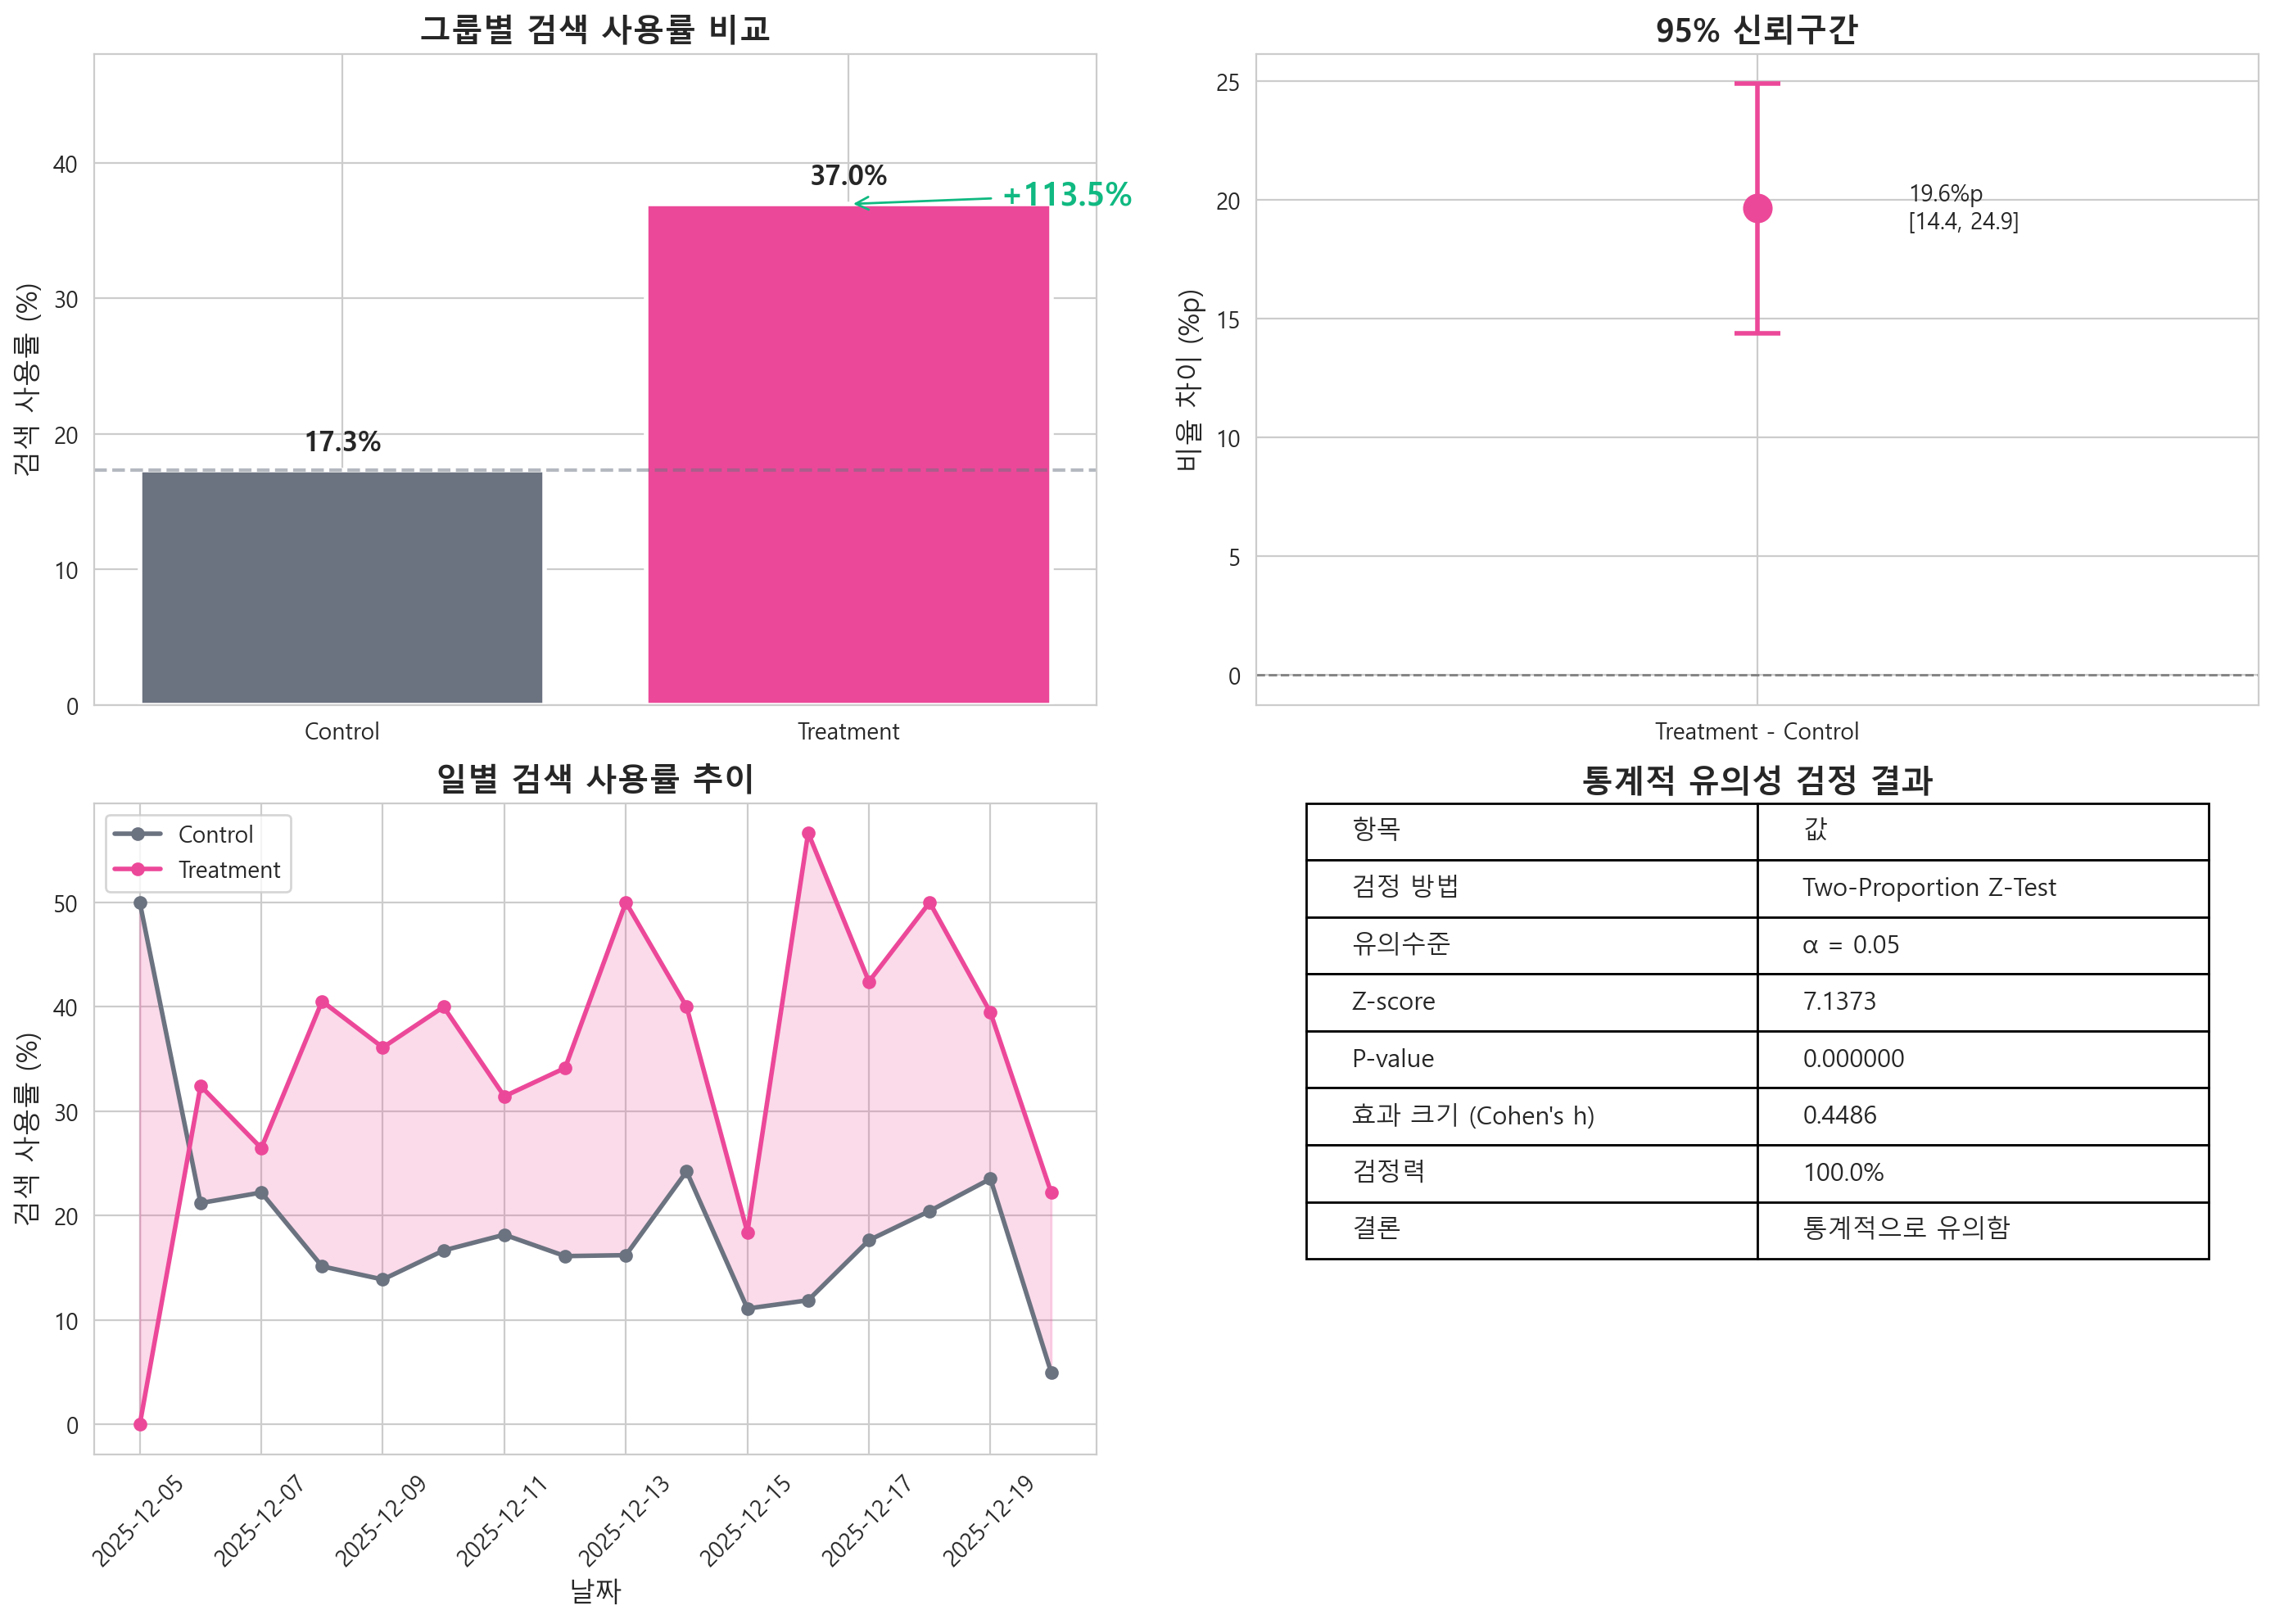


📊 시각화 저장 완료: ab_test_statistical_analysis.png


In [46]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 7-1. 그룹별 검색 사용률 비교
ax1 = axes[0, 0]
groups = ['Control', 'Treatment']
rates = [control['search_usage_rate'], treatment['search_usage_rate']]
colors = ['#6b7280', '#ec4899']

bars = ax1.bar(groups, rates, color=colors, edgecolor='white', linewidth=2)
ax1.set_ylabel('검색 사용률 (%)', fontsize=12)
ax1.set_title('그룹별 검색 사용률 비교', fontsize=14, fontweight='bold')

# 값 표시
for bar, rate in zip(bars, rates):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{rate:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Lift 표시
ax1.annotate(f'+{lift:.1f}%', xy=(1, treatment['search_usage_rate']), 
             xytext=(1.3, treatment['search_usage_rate']),
             fontsize=14, color='#10b981', fontweight='bold',
             arrowprops=dict(arrowstyle='->', color='#10b981'))

ax1.set_ylim(0, max(rates) * 1.3)
ax1.axhline(y=control['search_usage_rate'], color='#6b7280', linestyle='--', alpha=0.5)

# 7-2. 신뢰구간 시각화
ax2 = axes[0, 1]
ax2.errorbar([1], [diff*100], yerr=[[diff*100 - ci_lower*100], [ci_upper*100 - diff*100]], 
             fmt='o', markersize=12, color='#ec4899', capsize=10, capthick=2, elinewidth=2)
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax2.set_xlim(0.5, 1.5)
ax2.set_xticks([1])
ax2.set_xticklabels(['Treatment - Control'])
ax2.set_ylabel('비율 차이 (%p)', fontsize=12)
ax2.set_title('95% 신뢰구간', fontsize=14, fontweight='bold')

# CI 값 표시
ax2.text(1.15, diff*100, f'{diff*100:.1f}%p\n[{ci_lower*100:.1f}, {ci_upper*100:.1f}]', 
         fontsize=10, va='center')

# 7-3. 일별 추이
ax3 = axes[1, 0]
daily_df = pd.DataFrame(data['daily_trend'])

# 피벗 테이블 생성
daily_pivot = daily_df.pivot(index='date', columns='variant', values='search_rate')
daily_pivot = daily_pivot.reset_index()
daily_pivot['date'] = pd.to_datetime(daily_pivot['date'])

ax3.plot(daily_pivot['date'], daily_pivot['control'], 'o-', color='#6b7280', 
         label='Control', linewidth=2, markersize=5)
ax3.plot(daily_pivot['date'], daily_pivot['treatment'], 'o-', color='#ec4899', 
         label='Treatment', linewidth=2, markersize=5)

ax3.fill_between(daily_pivot['date'], daily_pivot['control'], daily_pivot['treatment'], 
                 alpha=0.2, color='#ec4899')

ax3.set_xlabel('날짜', fontsize=12)
ax3.set_ylabel('검색 사용률 (%)', fontsize=12)
ax3.set_title('일별 검색 사용률 추이', fontsize=14, fontweight='bold')
ax3.legend(loc='upper left')
ax3.tick_params(axis='x', rotation=45)

# 7-4. 통계적 유의성 요약
ax4 = axes[1, 1]
ax4.axis('off')

rows = [
    ["검정 방법", "Two-Proportion Z-Test"],
    ["유의수준", "α = 0.05"],
    ["Z-score", f"{z_score:.4f}"],
    ["P-value", f"{p_value:.6f}"],
    ["효과 크기 (Cohen's h)", f"{cohens_h:.4f}"],
    ["검정력", f"{power*100:.1f}%"],
    ["결론", "통계적으로 유의함" if p_value < 0.05 else "유의하지 않음"],
]

tbl = ax4.table(
    cellText=rows,
    colLabels=["항목", "값"],
    cellLoc="left",
    colLoc="left",
    loc="upper center",
    bbox=[0.05, 0.3, 0.90, 0.70]
)

# 보기 좋게
tbl.auto_set_font_size(False)
tbl.set_fontsize(11)
tbl.scale(1, 1.6)

ax4.set_title("통계적 유의성 검정 결과", fontsize=14, fontweight="bold", pad=5)

plt.tight_layout()
plt.savefig('ab_test_statistical_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


print("\n📊 시각화 저장 완료: ab_test_statistical_analysis.png")

## 8. 최종 결론 및 권장사항

In [12]:
print("\n" + "=" * 60)
print("📋 A/B 테스트 최종 분석 리포트")
print("=" * 60)

print(f"""
┌─────────────────────────────────────────────────────────────┐
│ 실험 정보                                                   │
├─────────────────────────────────────────────────────────────┤
│ 실험명:   {data['experiment']['name']:<47} │
│ 기간:     {data['experiment']['start_date']} ~ {data['experiment']['end_date']:<28} │
│ 가설:     검색창을 대시보드 상단에 배치하면                 │
│           검색 사용률이 20% 이상 증가할 것이다              │
└─────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────┐
│ 1차 지표 결과: 검색 사용률                                  │
├─────────────────────────────────────────────────────────────┤
│ Control:    {control['search_usage_rate']:>6.2f}% ({control['sessions_with_search']:>3}/{control['total_sessions']:<3} 세션)                      │
│ Treatment:  {treatment['search_usage_rate']:>6.2f}% ({treatment['sessions_with_search']:>3}/{treatment['total_sessions']:<3} 세션)                      │
│ Lift:       +{lift:>5.1f}%                                              │
└─────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────┐
│ 통계적 검정 결과                                            │
├─────────────────────────────────────────────────────────────┤
│ Z-score:        {z_score:>8.4f}                                       │
│ P-value:        {p_value:>8.6f}                                     │
│ 95% CI:         [{ci_lower*100:>5.2f}%p, {ci_upper*100:>5.2f}%p]                          │
│ Cohen's h:      {cohens_h:>8.4f} ({effect_size_text})                     │
│ 검정력:         {power*100:>6.1f}%                                        │
└─────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────┐
│ 결론 및 권장사항                                            │
├─────────────────────────────────────────────────────────────┤
""")

if p_value < 0.05 and diff > 0:
    print("""│ ✅ 가설 검증됨                                              │
│                                                             │
│ • Treatment(대시보드 검색창)가 Control 대비 통계적으로      │
│   유의미하게 높은 검색 사용률을 보임                        │
│ • 95% 신뢰수준에서 효과가 확인됨                            │
│                                                             │
│ 📌 권장: Treatment를 전체 사용자에게 배포                   │
└─────────────────────────────────────────────────────────────┘""")
else:
    print("""│ ❌ 가설 검증 실패 또는 추가 데이터 필요                     │
└─────────────────────────────────────────────────────────────┘""")


📋 A/B 테스트 최종 분석 리포트

┌─────────────────────────────────────────────────────────────┐
│ 실험 정보                                                   │
├─────────────────────────────────────────────────────────────┤
│ 실험명:   대시보드 검색창 노출 테스트                                 │
│ 기간:     2025-12-06 ~ 2025-12-20                   │
│ 가설:     검색창을 대시보드 상단에 배치하면                 │
│           검색 사용률이 20% 이상 증가할 것이다              │
└─────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────┐
│ 1차 지표 결과: 검색 사용률                                  │
├─────────────────────────────────────────────────────────────┤
│ Control:     17.31% ( 90/520 세션)                      │
│ Treatment:   36.95% (194/525 세션)                      │
│ Lift:       +113.5%                                              │
└─────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────┐
│ 통계적 검정 결과        

## 9. 2차 지표 Trade-off 분석

In [13]:
print("\n" + "=" * 60)
print("📊 2차 지표 Trade-off 분석")
print("=" * 60)

search_ctr = data['secondary_metrics']['search_ctr']
registration = data['secondary_metrics']['registration_rate']

print(f"""
┌─────────────────────────────────────────────────────────────┐
│ Search CTR (검색 후 클릭률)                                 │
├─────────────────────────────────────────────────────────────┤
│ Control:    {search_ctr['control']['search_ctr']:>5.2f}% ({search_ctr['control']['searches_with_click']}/{search_ctr['control']['total_searches']} 검색)              │
│ Treatment:  {search_ctr['treatment']['search_ctr']:>5.2f}% ({search_ctr['treatment']['searches_with_click']}/{search_ctr['treatment']['total_searches']} 검색)             │
│ 변화:       {search_ctr['treatment']['search_ctr'] - search_ctr['control']['search_ctr']:>+5.2f}%p                                          │
├─────────────────────────────────────────────────────────────┤
│ 해석: Treatment에서 CTR이 소폭 감소                         │
│       → 캐주얼/탐색적 검색이 증가했기 때문 (예상된 결과)    │
└─────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────┐
│ 성분 등록 전환율 (검색 클릭 → 성분 등록)                    │
├─────────────────────────────────────────────────────────────┤
│ Control:    {registration['control']['registration_rate']:>5.2f}% ({registration['control']['registrations']}/{registration['control']['searches_with_click']} 클릭)               │
│ Treatment:  {registration['treatment']['registration_rate']:>5.2f}% ({registration['treatment']['registrations']}/{registration['treatment']['searches_with_click']} 클릭)              │
│ 변화:       {registration['treatment']['registration_rate'] - registration['control']['registration_rate']:>+5.2f}%p                                          │
├─────────────────────────────────────────────────────────────┤
│ 해석: Treatment에서 전환율 감소                             │
│       → 그러나 절대 전환 수는 증가 (26 → 38)                │
│       → 검색 증가로 인한 전체 가치 상승                     │
└─────────────────────────────────────────────────────────────┘
""")

# 절대 수치 비교
print("📈 절대 수치 비교 (더 중요한 지표)")
print("-" * 40)
print(f"검색 세션:    {control['sessions_with_search']:>3} → {treatment['sessions_with_search']:>3} (+{treatment['sessions_with_search']-control['sessions_with_search']:>3}, {(treatment['sessions_with_search']-control['sessions_with_search'])/control['sessions_with_search']*100:>+.1f}%)")
print(f"검색 클릭:    {search_ctr['control']['searches_with_click']:>3} → {search_ctr['treatment']['searches_with_click']:>3} (+{search_ctr['treatment']['searches_with_click']-search_ctr['control']['searches_with_click']:>3}, {(search_ctr['treatment']['searches_with_click']-search_ctr['control']['searches_with_click'])/search_ctr['control']['searches_with_click']*100:>+.1f}%)")
print(f"성분 등록:    {registration['control']['registrations']:>3} → {registration['treatment']['registrations']:>3} (+{registration['treatment']['registrations']-registration['control']['registrations']:>3}, {(registration['treatment']['registrations']-registration['control']['registrations'])/registration['control']['registrations']*100:>+.1f}%)")


📊 2차 지표 Trade-off 분석

┌─────────────────────────────────────────────────────────────┐
│ Search CTR (검색 후 클릭률)                                 │
├─────────────────────────────────────────────────────────────┤
│ Control:    51.26% (61/119 검색)              │
│ Treatment:  45.32% (126/278 검색)             │
│ 변화:       -5.94%p                                          │
├─────────────────────────────────────────────────────────────┤
│ 해석: Treatment에서 CTR이 소폭 감소                         │
│       → 캐주얼/탐색적 검색이 증가했기 때문 (예상된 결과)    │
└─────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────┐
│ 성분 등록 전환율 (검색 클릭 → 성분 등록)                    │
├─────────────────────────────────────────────────────────────┤
│ Control:    42.62% (26/61 클릭)               │
│ Treatment:  30.16% (38/126 클릭)              │
│ 변화:       -12.46%p                                          │
├─────────────────────────────────────────────────────────────┤
│ 해